In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

panel = pd.read_csv("../data/processed/returns_panel.csv")

panel.head()


,date,open,high,low,close,volume,openint,symbol,return_1d
0,1999-11-19,28.986,29.027,26.872,27.257,16142920,0,a.us,-0.082318
1,1999-11-22,27.886,29.702,27.044,29.702,6970266,0,a.us,0.089702
2,1999-11-23,28.688,29.446,27.002,27.002,6332082,0,a.us,-0.090903
3,1999-11-24,27.083,28.309,27.002,27.717,5132147,0,a.us,0.026480
4,1999-11-26,27.594,28.012,27.509,27.807,1832635,0,a.us,0.003247


In [12]:
panel["date"] = pd.to_datetime(panel["date"])
panel = panel.sort_values(["symbol", "date"])

for lag in [1, 5, 20]:
    panel[f"ret_lag_{lag}"] = (
        panel.groupby("symbol")["return_1d"].shift(lag)
    )

panel["vol_20"] = (
    panel.groupby("symbol")["return_1d"]
    .rolling(20)
    .std()
    .reset_index(level=0, drop=True)
)

panel = panel.dropna()

In [13]:
train = panel[panel["date"] < "2015-01-01"]
test  = panel[panel["date"] >= "2015-01-01"]

features = ["ret_lag_1", "ret_lag_5", "ret_lag_20", "vol_20"]

X_train = train[features]
y_train = train["return_1d"]

X_test = test[features]
y_test = test["return_1d"]

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

print("Linear MSE:", mean_squared_error(y_test, pred_lr))
print("Linear R2:", r2_score(y_test, pred_lr))

Linear MSE: 0.008002189571083219
Linear R2: -1.5506253396607055


In [15]:
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("RF MSE:", mean_squared_error(y_test, pred_rf))
print("RF R2:", r2_score(y_test, pred_rf))

RF MSE: 0.005301829613099028
RF R2: -0.6899100974314152


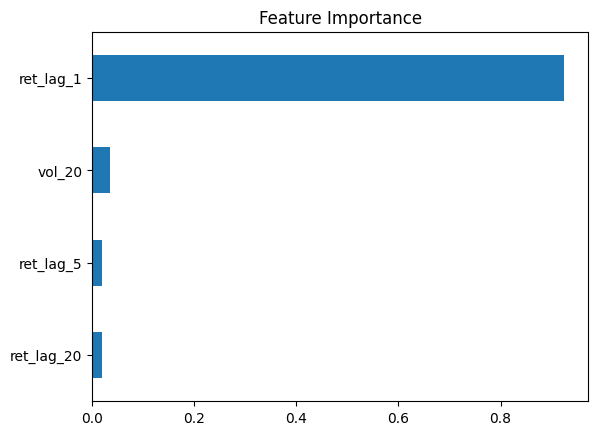

<Figure size 640x480 with 0 Axes>

In [19]:
imp = pd.Series(rf.feature_importances_, index=features)
imp.sort_values().plot(kind="barh", title="Feature Importance")
plt.show()
plt.savefig("../figures/feature_importance.png")

In [18]:
results = pd.DataFrame({
    "Model": ["Linear", "RandomForest"],
    "MSE": [
        mean_squared_error(y_test, pred_lr),
        mean_squared_error(y_test, pred_rf)
    ],
    "R2": [
        r2_score(y_test, pred_lr),
        r2_score(y_test, pred_rf)
    ]
})

results.to_csv("../results/model_comparison.csv", index=False)